# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from exercise_code.classifiers.fc_net import *
from exercise_code.data_utils import get_CIFAR10_data
from exercise_code.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from exercise_code.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (48000, 3, 32, 32)
y_train:  (48000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine layer: foward
Open the file `exercise_code/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.517821624638676e-10
dw error:  5.402370867234484e-11
db error:  3.8022108312495084e-10


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756002620448887e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `exercise_code/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from exercise_code.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  5.860460128757379e-10
dw error:  3.638418565723399e-10
db error:  1.1378131775571572e-11


# Loss layers: Softmax
You implemented this loss function in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `exercise_code/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302550916986689
dx error:  8.02942952622554e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `exercise_code/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-8, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-8, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)
  assert grads != {}, 'Problem with gradients (empty dict)'

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss
Running numeric gradient check with reg =  0.0
W1 relative error: 2.14e-08
W2 relative error: 1.20e-08
b1 relative error: 1.20e-08
b2 relative error: 1.09e-08
Running numeric gradient check with reg =  0.7
W1 relative error: 3.12e-07
W2 relative error: 7.86e-07
b1 relative error: 1.56e-08
b2 relative error: 1.06e-08


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `exercise_code/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet(hidden_dim=150, reg=1e-3, weight_scale=1e-3)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data, 
                update_rule='sgd',
                optim_config={'learning_rate':1e-3},
                lr_decay=0.95,
                batch_size=256,
                num_epochs=10,
                print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1870) loss: 2.301618
(Epoch 0 / 10) train acc: 0.129000; val_acc: 0.138000
(Iteration 101 / 1870) loss: 1.786292
(Epoch 1 / 10) train acc: 0.414000; val_acc: 0.401000
(Iteration 201 / 1870) loss: 1.600427
(Iteration 301 / 1870) loss: 1.609776
(Epoch 2 / 10) train acc: 0.476000; val_acc: 0.462000
(Iteration 401 / 1870) loss: 1.528723
(Iteration 501 / 1870) loss: 1.549744
(Epoch 3 / 10) train acc: 0.477000; val_acc: 0.484000
(Iteration 601 / 1870) loss: 1.469524
(Iteration 701 / 1870) loss: 1.519897
(Epoch 4 / 10) train acc: 0.495000; val_acc: 0.486000
(Iteration 801 / 1870) loss: 1.354142
(Iteration 901 / 1870) loss: 1.434535
(Epoch 5 / 10) train acc: 0.537000; val_acc: 0.493000
(Iteration 1001 / 1870) loss: 1.378787
(Iteration 1101 / 1870) loss: 1.314260
(Epoch 6 / 10) train acc: 0.525000; val_acc: 0.507000
(Iteration 1201 / 1870) loss: 1.328181
(Iteration 1301 / 1870) loss: 1.253731
(Epoch 7 / 10) train acc: 0.565000; val_acc: 0.511000
(Iteration 1401 / 1870) loss: 1.30

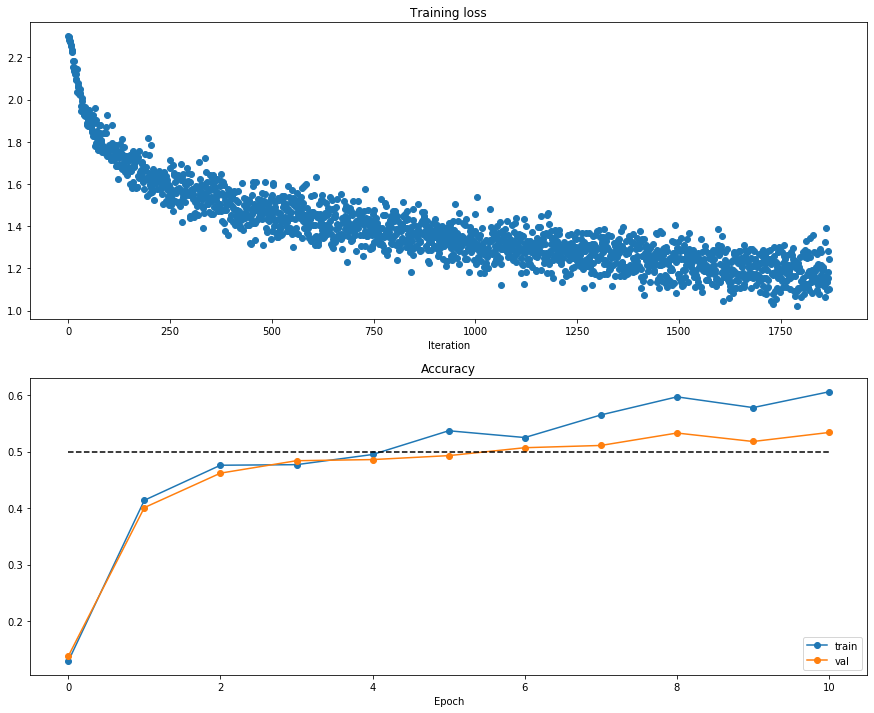

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `exercise_code/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.304926399617921
W1 relative error: 1.59e-06
W2 relative error: 4.89e-07
W3 relative error: 7.20e-08
b1 relative error: 2.91e-07
b2 relative error: 5.31e-09
b3 relative error: 6.16e-10
Running check with reg =  3.14
Initial loss:  7.0450782626403825
W1 relative error: 4.18e-07
W2 relative error: 2.23e-08
W3 relative error: 1.31e-08
b1 relative error: 4.04e-08
b2 relative error: 1.74e-08
b3 relative error: 8.71e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% **training** accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.278474
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.104000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.102000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.117000
(Epoch 3 / 20) train acc: 0.460000; val_acc: 0.144000
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.129000
(Epoch 5 / 20) train acc: 0.620000; val_acc: 0.144000
(Iteration 11 / 40) loss: 1.146434
(Epoch 6 / 20) train acc: 0.560000; val_acc: 0.141000
(Epoch 7 / 20) train acc: 0.660000; val_acc: 0.162000
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.171000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.174000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.172000
(Iteration 21 / 40) loss: 0.297141
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.172000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.177000
(Epoch 13 / 20) train acc: 0.920000; val_acc: 0.176000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.167000
(Epoch 15 / 20) train acc: 0.880000; val_acc: 0.167000
(Iteration 31 / 40) loss: 

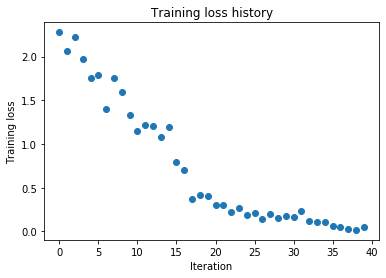

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

#############################################################################
# TODO: Maybe tweak values                                                  #
#############################################################################
weight_scale = 1e-2
learning_rate = 1e-2

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

#############################################################################
# TODO: Maybe tweak values                                                  #
#############################################################################
learning_rates = np.linspace(1e-1, 1e-10, num=10)
weight_scales = np.linspace(1e-1, 1e-10, num=10)
best_acc = 0.0
best_hyperparams = None

for learning_rate in learning_rates:
    for weight_scale in weight_scales:
        model = FullyConnectedNet([100, 100, 100, 100],
                        weight_scale=weight_scale, dtype=np.float64)
        solver = Solver(model, small_data,
                        print_every=50, num_epochs=60, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': learning_rate,
                        }
                 )
        solver.train()
        
        acc = solver.check_accuracy(small_data['X_train'], small_data['y_train'])
        print('Solver acc:', acc)
        if best_acc < acc:
            best_acc = acc
            best_hyperparams = (learning_rate, weight_scale)        
            
print('Best acc and hyperparams')
print(best_acc)
print(best_hyperparams)
            
        

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

#####################################################################################

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 120) loss: 18.973261
(Epoch 0 / 60) train acc: 0.120000; val_acc: 0.113000
(Epoch 1 / 60) train acc: 0.120000; val_acc: 0.094000
(Epoch 2 / 60) train acc: 0.120000; val_acc: 0.113000
(Epoch 3 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 6 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 7 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 8 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 9 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 10 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 11 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 12 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 13 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 14 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 17 / 60) train acc: 0.220000; va

(Epoch 35 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: nan
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.2200

(Epoch 1 / 60) train acc: 0.080000; val_acc: 0.111000
(Epoch 2 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 3 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 6 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 7 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 8 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 9 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 10 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 11 / 60) train acc: 0.140000; val_acc: 0.096000
(Epoch 12 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 13 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 14 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 17 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 18 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 19 / 60) tra

(Epoch 34 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 35 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: nan
(Epoch 51 / 60) train acc: 0.2200

(Iteration 1 / 120) loss: 22.104817
(Epoch 0 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 1 / 60) train acc: 0.140000; val_acc: 0.093000
(Epoch 2 / 60) train acc: 0.100000; val_acc: 0.083000
(Epoch 3 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 6 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 7 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 8 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 9 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 10 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 11 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 12 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 13 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 14 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 17 / 60) train acc: 0.220000; va

(Epoch 29 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 30 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 31 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 32 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 33 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 34 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 35 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 

(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0.220000; val_acc: 0.100000
Solver acc: 0.22
(Iteration 1 / 120) loss: 4.578113
(Epoch 0 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 1 / 60) train acc: 0.120000; val_acc: 0.094000
(Epoch 2 / 60) train acc: 0.120000; val_acc: 0.094000
(Epoch 3 / 60) train acc: 0.120000; val_acc: 0.094000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 6 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 7 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 8 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 9 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 10 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 11 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 12 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 13 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 14 / 60) train a

(Epoch 24 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 25 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 51 / 120) loss: nan
(Epoch 26 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 27 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 28 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 29 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 30 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 31 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 32 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 33 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 34 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 35 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.22000

(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 57 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0.220000; val_acc: 0.100000
Solver acc: 0.22
(Iteration 1 / 120) loss: 18.548574
(Epoch 0 / 60) train acc: 0.140000; val_acc: 0.093000
(Epoch 1 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 2 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 3 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 6 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 7 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 8 / 60) train

(Epoch 25 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 51 / 120) loss: nan
(Epoch 26 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 27 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 28 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 29 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 30 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 31 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 32 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 33 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 34 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 35 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.22000

(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 57 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0.220000; val_acc: 0.100000
Solver acc: 0.22
(Iteration 1 / 120) loss: 3.408869
(Epoch 0 / 60) train acc: 0.220000; val_acc: 0.099000
(Epoch 1 / 60) train acc: 0.120000; val_acc: 0.096000
(Epoch 2 / 60) train acc: 0.120000; val_acc: 0.094000
(Epoch 3 / 60) train acc: 0.100000; val_acc: 0.083000
(Epoch 4 / 60) train acc: 0.120000; val_acc: 0.094000
(Epoch 5 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 6 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 7 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 8 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 9 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 10 / 60) train a

(Epoch 19 / 60) train acc: 0.300000; val_acc: 0.112000
(Epoch 20 / 60) train acc: 0.440000; val_acc: 0.133000
(Epoch 21 / 60) train acc: 0.420000; val_acc: 0.152000
(Epoch 22 / 60) train acc: 0.220000; val_acc: 0.133000
(Epoch 23 / 60) train acc: 0.320000; val_acc: 0.164000
(Epoch 24 / 60) train acc: 0.480000; val_acc: 0.164000
(Epoch 25 / 60) train acc: 0.440000; val_acc: 0.134000
(Iteration 51 / 120) loss: 1.438754
(Epoch 26 / 60) train acc: 0.400000; val_acc: 0.128000
(Epoch 27 / 60) train acc: 0.520000; val_acc: 0.166000
(Epoch 28 / 60) train acc: 0.520000; val_acc: 0.145000
(Epoch 29 / 60) train acc: 0.560000; val_acc: 0.163000
(Epoch 30 / 60) train acc: 0.400000; val_acc: 0.132000
(Epoch 31 / 60) train acc: 0.460000; val_acc: 0.133000
(Epoch 32 / 60) train acc: 0.400000; val_acc: 0.158000
(Epoch 33 / 60) train acc: 0.420000; val_acc: 0.102000
(Epoch 34 / 60) train acc: 0.560000; val_acc: 0.121000
(Epoch 35 / 60) train acc: 0.640000; val_acc: 0.154000
(Epoch 36 / 60) train acc: 0.

(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: 2.228901
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 57 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0

(Epoch 17 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 18 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 19 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 20 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 21 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 22 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 23 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 24 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 25 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 51 / 120) loss: nan
(Epoch 26 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 27 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 28 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 29 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 30 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 31 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 32 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 33 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 34 / 60) train acc: 0.22000

(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: nan
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 57 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0.220000; val_acc: 0.100000
Solver acc: 0.12
(Iteration 1 / 120) loss: 3.016706
(Epoch 0 / 60) train acc: 0.140000; val_acc: 0.121000
(Epoch 1 / 60) train acc: 0.080000; v

(Epoch 13 / 60) train acc: 0.080000; val_acc: 0.101000
(Epoch 14 / 60) train acc: 0.240000; val_acc: 0.108000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.103000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.091000
(Epoch 17 / 60) train acc: 0.280000; val_acc: 0.114000
(Epoch 18 / 60) train acc: 0.280000; val_acc: 0.119000
(Epoch 19 / 60) train acc: 0.360000; val_acc: 0.116000
(Epoch 20 / 60) train acc: 0.280000; val_acc: 0.124000
(Epoch 21 / 60) train acc: 0.340000; val_acc: 0.103000
(Epoch 22 / 60) train acc: 0.320000; val_acc: 0.123000
(Epoch 23 / 60) train acc: 0.320000; val_acc: 0.103000
(Epoch 24 / 60) train acc: 0.240000; val_acc: 0.098000
(Epoch 25 / 60) train acc: 0.260000; val_acc: 0.100000
(Iteration 51 / 120) loss: 3.090246
(Epoch 26 / 60) train acc: 0.340000; val_acc: 0.105000
(Epoch 27 / 60) train acc: 0.400000; val_acc: 0.128000
(Epoch 28 / 60) train acc: 0.380000; val_acc: 0.127000
(Epoch 29 / 60) train acc: 0.360000; val_acc: 0.119000
(Epoch 30 / 60) train acc: 0.

(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: 2.308968
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0

(Epoch 8 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 9 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 10 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 11 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 12 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 13 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 14 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 17 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 18 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 19 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 20 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 21 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 22 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 23 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 24 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 25 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 5

(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: nan
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 57 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0.220000; val_acc: 0.100000
Solver acc: 0.24
(Iteration 1 / 1

(Epoch 14 / 60) train acc: 0.300000; val_acc: 0.136000
(Epoch 15 / 60) train acc: 0.740000; val_acc: 0.167000
(Epoch 16 / 60) train acc: 0.760000; val_acc: 0.167000
(Epoch 17 / 60) train acc: 0.780000; val_acc: 0.177000
(Epoch 18 / 60) train acc: 0.620000; val_acc: 0.161000
(Epoch 19 / 60) train acc: 0.580000; val_acc: 0.149000
(Epoch 20 / 60) train acc: 0.680000; val_acc: 0.146000
(Epoch 21 / 60) train acc: 0.780000; val_acc: 0.168000
(Epoch 22 / 60) train acc: 0.840000; val_acc: 0.181000
(Epoch 23 / 60) train acc: 0.860000; val_acc: 0.180000
(Epoch 24 / 60) train acc: 0.840000; val_acc: 0.162000
(Epoch 25 / 60) train acc: 0.660000; val_acc: 0.141000
(Iteration 51 / 120) loss: 1.229972
(Epoch 26 / 60) train acc: 0.520000; val_acc: 0.149000
(Epoch 27 / 60) train acc: 0.580000; val_acc: 0.143000
(Epoch 28 / 60) train acc: 0.740000; val_acc: 0.172000
(Epoch 29 / 60) train acc: 0.840000; val_acc: 0.165000
(Epoch 30 / 60) train acc: 0.840000; val_acc: 0.167000
(Epoch 31 / 60) train acc: 0.

(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: 2.206319
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 57 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 58 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 59 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 60 / 60) train acc: 0.220000; val_acc: 0.100000
Solver acc: 0.22
(Iteration 

(Epoch 14 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 17 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 18 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 19 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 20 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 21 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 22 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 23 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 24 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 25 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 51 / 120) loss: nan
(Epoch 26 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 27 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 28 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 29 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 30 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 31 / 60) train acc: 0.22000

(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: nan
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 55 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 56 / 60) train acc: 0.2200

(Epoch 0 / 60) train acc: 0.260000; val_acc: 0.134000
(Epoch 1 / 60) train acc: 0.240000; val_acc: 0.136000
(Epoch 2 / 60) train acc: 0.320000; val_acc: 0.152000
(Epoch 3 / 60) train acc: 0.300000; val_acc: 0.108000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.340000; val_acc: 0.125000
(Epoch 6 / 60) train acc: 0.400000; val_acc: 0.156000
(Epoch 7 / 60) train acc: 0.460000; val_acc: 0.164000
(Epoch 8 / 60) train acc: 0.260000; val_acc: 0.142000
(Epoch 9 / 60) train acc: 0.500000; val_acc: 0.153000
(Epoch 10 / 60) train acc: 0.500000; val_acc: 0.169000
(Epoch 11 / 60) train acc: 0.360000; val_acc: 0.125000
(Epoch 12 / 60) train acc: 0.480000; val_acc: 0.164000
(Epoch 13 / 60) train acc: 0.560000; val_acc: 0.180000
(Epoch 14 / 60) train acc: 0.580000; val_acc: 0.169000
(Epoch 15 / 60) train acc: 0.640000; val_acc: 0.151000
(Epoch 16 / 60) train acc: 0.680000; val_acc: 0.166000
(Epoch 17 / 60) train acc: 0.500000; val_acc: 0.168000
(Epoch 18 / 60) trai

(Epoch 32 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 33 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 34 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 35 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 

(Epoch 2 / 60) train acc: 0.060000; val_acc: 0.092000
(Epoch 3 / 60) train acc: 0.100000; val_acc: 0.083000
(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 6 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 7 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 8 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 9 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 10 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 11 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 12 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 13 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 14 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 15 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 16 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 17 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 18 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 19 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 20 / 60) tr

(Epoch 36 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: nan
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.2200

(Epoch 4 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 5 / 60) train acc: 0.240000; val_acc: 0.101000
(Epoch 6 / 60) train acc: 0.420000; val_acc: 0.133000
(Epoch 7 / 60) train acc: 0.300000; val_acc: 0.128000
(Epoch 8 / 60) train acc: 0.340000; val_acc: 0.145000
(Epoch 9 / 60) train acc: 0.240000; val_acc: 0.103000
(Epoch 10 / 60) train acc: 0.500000; val_acc: 0.154000
(Epoch 11 / 60) train acc: 0.500000; val_acc: 0.177000
(Epoch 12 / 60) train acc: 0.540000; val_acc: 0.157000
(Epoch 13 / 60) train acc: 0.420000; val_acc: 0.159000
(Epoch 14 / 60) train acc: 0.500000; val_acc: 0.149000
(Epoch 15 / 60) train acc: 0.420000; val_acc: 0.137000
(Epoch 16 / 60) train acc: 0.400000; val_acc: 0.140000
(Epoch 17 / 60) train acc: 0.680000; val_acc: 0.169000
(Epoch 18 / 60) train acc: 0.640000; val_acc: 0.165000
(Epoch 19 / 60) train acc: 0.700000; val_acc: 0.147000
(Epoch 20 / 60) train acc: 0.660000; val_acc: 0.164000
(Epoch 21 / 60) train acc: 0.820000; val_acc: 0.170000
(Epoch 22 / 60) 

(Epoch 37 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 38 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 39 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 40 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 41 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 42 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 43 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 44 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 45 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 46 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 47 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 48 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 49 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 50 / 60) train acc: 0.220000; val_acc: 0.100000
(Iteration 101 / 120) loss: 2.218175
(Epoch 51 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 52 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 53 / 60) train acc: 0.220000; val_acc: 0.100000
(Epoch 54 / 60) train acc: 0

KeyboardInterrupt: 

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?</p>
</div>


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `exercise_code/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [ ]:
from exercise_code.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 400) loss: 2.308482
(Epoch 0 / 10) train acc: 0.135000; val_acc: 0.111000
(Iteration 11 / 400) loss: 2.298583
(Iteration 21 / 400) loss: 2.297192
(Iteration 31 / 400) loss: 2.288183
(Epoch 1 / 10) train acc: 0.123000; val_acc: 0.109000
(Iteration 41 / 400) loss: 2.279595
(Iteration 51 / 400) loss: 2.289479
(Iteration 61 / 400) loss: 2.290997
(Iteration 71 / 400) loss: 2.280042
(Epoch 2 / 10) train acc: 0.171000; val_acc: 0.160000
(Iteration 81 / 400) loss: 2.244322
(Iteration 91 / 400) loss: 2.256345
(Iteration 101 / 400) loss: 2.219628
(Iteration 111 / 400) loss: 2.206973
(Epoch 3 / 10) train acc: 0.186000; val_acc: 0.153000
(Iteration 121 / 400) loss: 2.079824
(Iteration 131 / 400) loss: 2.117488
(Iteration 141 / 400) loss: 2.084533
(Iteration 151 / 400) loss: 2.123914
(Epoch 4 / 10) train acc: 0.218000; val_acc: 0.204000
(Iteration 161 / 400) loss: 2.150052
(Iteration 171 / 400) loss: 2.102281
(Iteration 181 / 400) loss: 1.985956
(Iteration 191 / 400

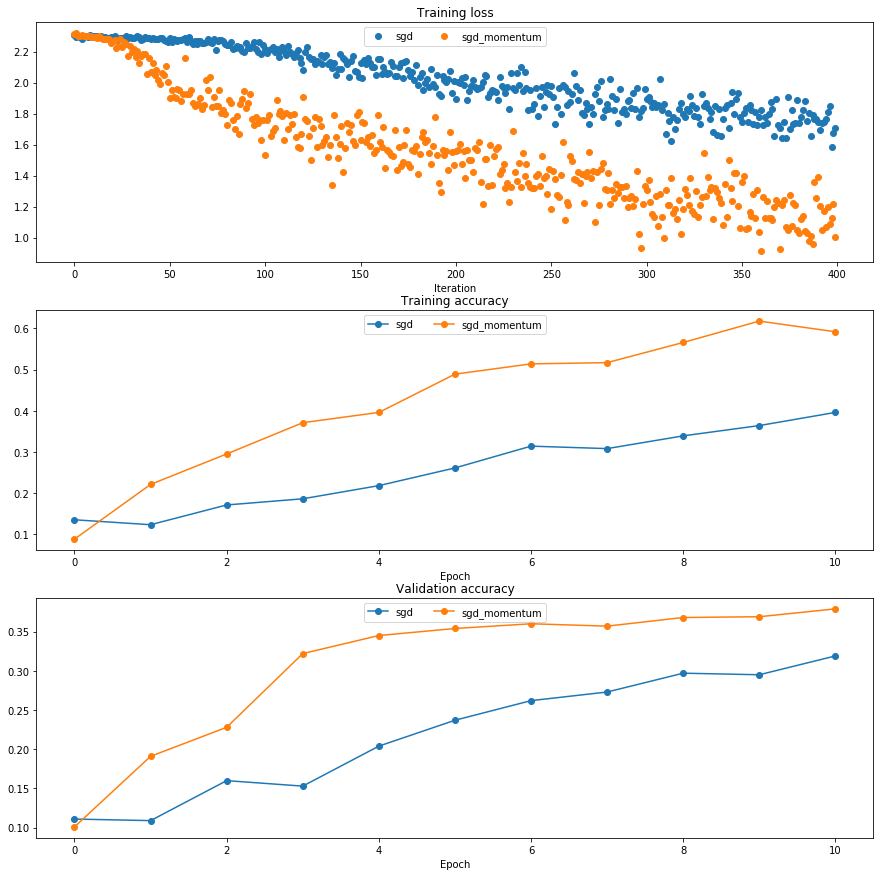

In [15]:
num_train = 4000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=3e-2)

    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=100,
                    update_rule=update_rule,
                    optim_config={'learning_rate': 1e-2},
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Adam [1] is an update rule that sets per-parameter learning rates by using a running average of the second moments of gradients.

In the file `exercise_code/optim.py`, we have implemented the update rule `adam` for you. Check this implementation and make sure you understand what the optimizer is doing. Then train the fully connected net below to see how Adam affects the learning process.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

running with  adam
(Iteration 1 / 200) loss: 2.632969
(Epoch 0 / 5) train acc: 0.165000; val_acc: 0.141000
(Iteration 11 / 200) loss: 2.075162
(Iteration 21 / 200) loss: 1.887636
(Iteration 31 / 200) loss: 1.750914
(Epoch 1 / 5) train acc: 0.347000; val_acc: 0.293000
(Iteration 41 / 200) loss: 1.963741
(Iteration 51 / 200) loss: 1.800006
(Iteration 61 / 200) loss: 1.714239
(Iteration 71 / 200) loss: 1.752711
(Epoch 2 / 5) train acc: 0.440000; val_acc: 0.349000
(Iteration 81 / 200) loss: 1.352993
(Iteration 91 / 200) loss: 1.718116
(Iteration 101 / 200) loss: 1.643278
(Iteration 111 / 200) loss: 1.473103
(Epoch 3 / 5) train acc: 0.511000; val_acc: 0.361000
(Iteration 121 / 200) loss: 1.443682
(Iteration 131 / 200) loss: 1.577836
(Iteration 141 / 200) loss: 1.339569
(Iteration 151 / 200) loss: 1.654278
(Epoch 4 / 5) train acc: 0.549000; val_acc: 0.370000
(Iteration 161 / 200) loss: 1.379240
(Iteration 171 / 200) loss: 1.534758
(Iteration 181 / 200) loss: 1.432727
(Iteration 191 / 200) lo

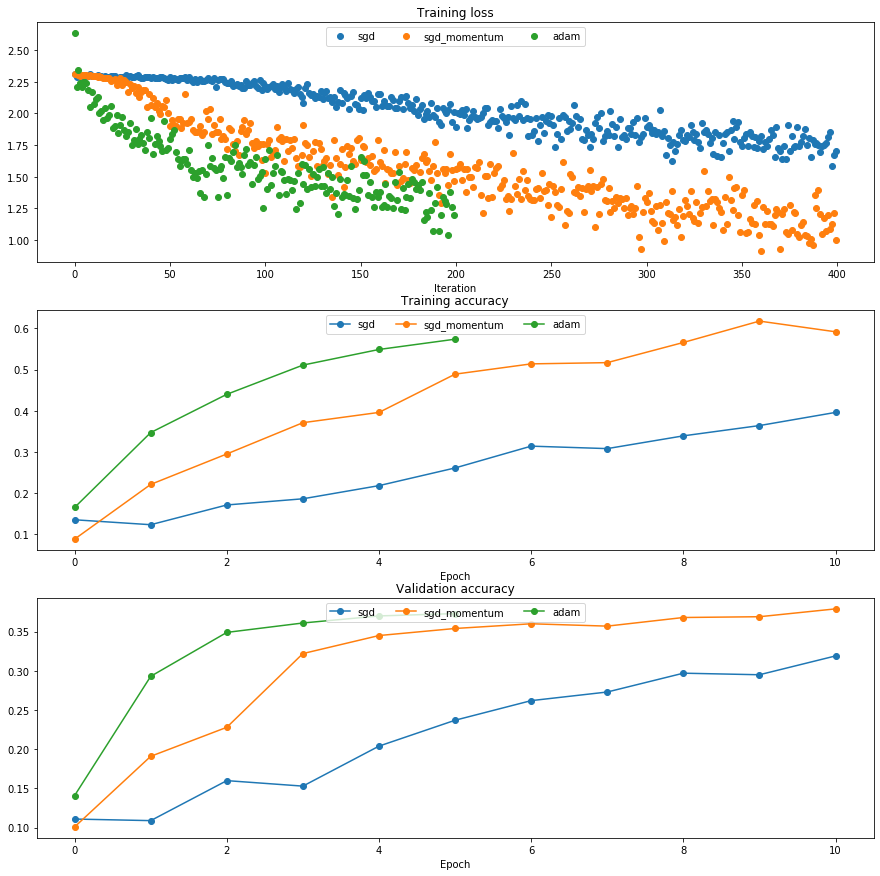

In [16]:
learning_rates = {'adam': 1e-3}
update_rule = 'adam'
print('running with ', update_rule)
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(model, small_data,
              num_epochs=5, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solvers[update_rule] = solver
solver.train()
print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least __50%__ accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `2_BatchNormalization.ipynb` and the `3_Dropout.ipynb` notebooks before completing this part, since these techniques can help you train powerful models.

In [21]:
best_model = None
best_acc = 0

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
# Note that dropout is not required to pass beyond the linear scoring regime   #
################################################################################

learning_rates = np.linspace(1e-3, 1e-5, num=3)
weight_scales = np.linspace(1e-2, 1e-4, num=3)

for learning_rate in learning_rates:
    for weight_scale in weight_scales:
        model = FullyConnectedNet([100, 100, 100, 100],
                        weight_scale=weight_scale, dtype=np.float64)
        solver = Solver(model, data,
                        print_every=100, num_epochs=10, batch_size=250,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': learning_rate,
                        }
                 )
        solver.train()
        
        acc = solver.check_accuracy(small_data['X_val'], small_data['y_val'])
        if best_acc < acc:
            best_acc = acc
            best_model = model

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 1920) loss: 2.302635
(Epoch 0 / 10) train acc: 0.182000; val_acc: 0.163000
(Iteration 101 / 1920) loss: 1.728170
(Epoch 1 / 10) train acc: 0.416000; val_acc: 0.411000
(Iteration 201 / 1920) loss: 1.681942
(Iteration 301 / 1920) loss: 1.536002
(Epoch 2 / 10) train acc: 0.486000; val_acc: 0.454000
(Iteration 401 / 1920) loss: 1.388193
(Iteration 501 / 1920) loss: 1.437044
(Epoch 3 / 10) train acc: 0.525000; val_acc: 0.485000
(Iteration 601 / 1920) loss: 1.398260
(Iteration 701 / 1920) loss: 1.313988
(Epoch 4 / 10) train acc: 0.532000; val_acc: 0.485000
(Iteration 801 / 1920) loss: 1.393637
(Iteration 901 / 1920) loss: 1.190554
(Epoch 5 / 10) train acc: 0.554000; val_acc: 0.528000
(Iteration 1001 / 1920) loss: 1.250690
(Iteration 1101 / 1920) loss: 1.133648
(Epoch 6 / 10) train acc: 0.545000; val_acc: 0.506000
(Iteration 1201 / 1920) loss: 1.141652
(Iteration 1301 / 1920) loss: 1.235498
(Epoch 7 / 10) train acc: 0.588000; val_acc: 0.510000
(Iteration 1401 / 1920) loss: 1.21

(Iteration 101 / 1920) loss: 2.299444
(Epoch 1 / 10) train acc: 0.199000; val_acc: 0.196000
(Iteration 201 / 1920) loss: 2.250681
(Iteration 301 / 1920) loss: 2.147398
(Epoch 2 / 10) train acc: 0.240000; val_acc: 0.241000
(Iteration 401 / 1920) loss: 2.004088
(Iteration 501 / 1920) loss: 2.000957
(Epoch 3 / 10) train acc: 0.247000; val_acc: 0.249000
(Iteration 601 / 1920) loss: 1.904324
(Iteration 701 / 1920) loss: 1.991238
(Epoch 4 / 10) train acc: 0.301000; val_acc: 0.259000
(Iteration 801 / 1920) loss: 1.952464
(Iteration 901 / 1920) loss: 1.829041
(Epoch 5 / 10) train acc: 0.285000; val_acc: 0.262000
(Iteration 1001 / 1920) loss: 1.919933
(Iteration 1101 / 1920) loss: 1.863446
(Epoch 6 / 10) train acc: 0.310000; val_acc: 0.274000
(Iteration 1201 / 1920) loss: 1.889115
(Iteration 1301 / 1920) loss: 1.833203
(Epoch 7 / 10) train acc: 0.291000; val_acc: 0.284000
(Iteration 1401 / 1920) loss: 1.847082
(Iteration 1501 / 1920) loss: 1.725604
(Epoch 8 / 10) train acc: 0.319000; val_acc: 0

# Test your model
Run your best model on the validation and test sets. You should achieve score of above __50%__ accuracy on the validation set.

In [23]:
X_test = data['X_test']
X_val = data['X_val']
y_val = data['y_val']
y_test = data['y_test']

y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())

Validation set accuracy:  0.546
Test set accuracy:  0.52


## Save the model

When you are satisfied with your training, save the model for submission.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle <class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [24]:
from exercise_code.model_savers import save_fully_connected_net
save_fully_connected_net(best_model)